## Welcome to the `PSPNet` Workshop!
In this workshop, we'll build on the PSPNet_starter Notebook and build a full fledged PSPNet (Pyramid Scene Parsing Net), use it for Semantic Segmentation using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define PSPNet model using resnet50 backbone, Pyramid Pooling Module architecture and Auxilary loss
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

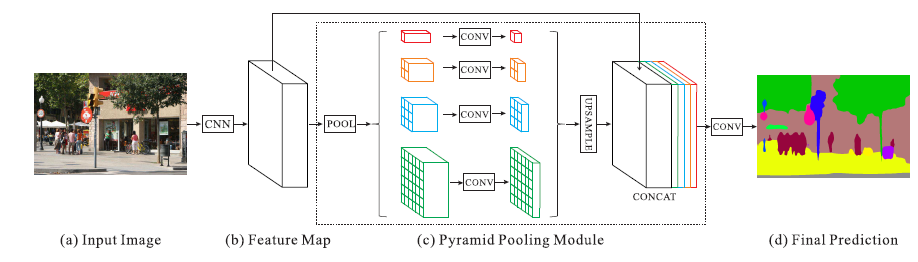

[Image reference](https://arxiv.org/abs/1612.01105)

In [1]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 
     |████████████████████████████████| 376 kB 33.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d19b4df5b8a18e0449218a9b28789ddb512ce9e4e5b2988303dbe0c2cf831ad2
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=263bc202f28251912f856b01cb38054ef43a5c44addc1bf7e4c6edf016651087
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


# Basic Imports

In [2]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use BDD100k dataset

In [3]:
ENVIRONMENT = 'colab'

if ENVIRONMENT == 'kaggle':
    dataset_path = '../input/image-segmentation'
    output_path = '.'
    
elif ENVIRONMENT == 'colab':
    import os
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation/finalContent")
    dataset_path = 'dataset'
    output_path = 'dataset'
    
else:
    raise NotImplementedError("Env can be kaggle or colab")

Mounted at /content/drive


In [4]:
targetWidth = 320
targetHeight = 180
# dataset_path = 'dataset'
images = np.load(f'{dataset_path}/image_{targetHeight}_{targetWidth}.npy')
labels = np.load(f'{dataset_path}/label_{targetHeight}_{targetWidth}.npy')
print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3430, 180, 320, 3), Label images shape = (3430, 180, 320)


In [5]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


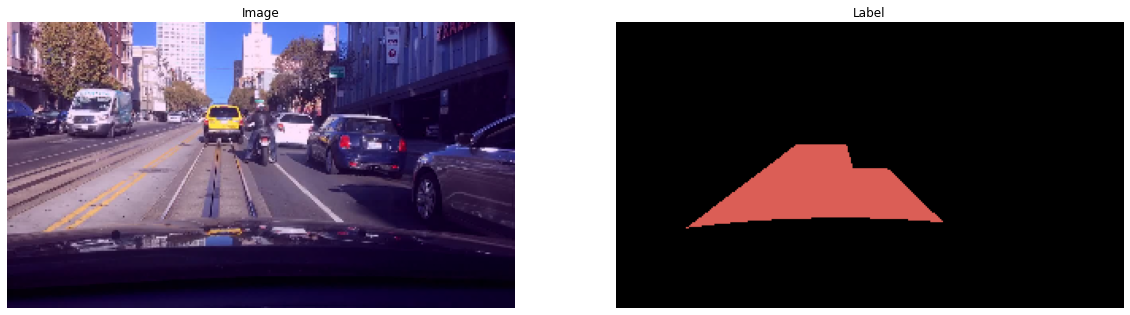

In [6]:
from utils import inverse_transform, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : Define PSPNet model using resnet50 backbone, Pyramid Pooling Module architecture and Auxilary loss

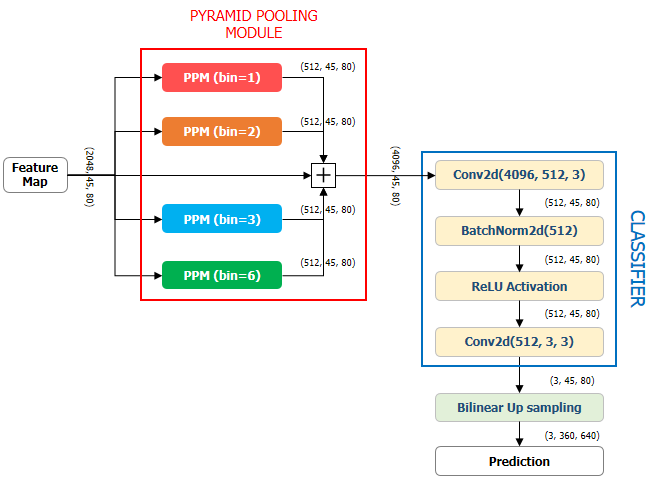

In [7]:
class pyramid_pooling_module(nn.Module):
    def __init__(self, in_channels, out_channels, bin_sizes):
        super(pyramid_pooling_module, self).__init__()
        
        # create pyramid pooling layers for each level
        self.pyramid_pool_layers = []
        for bin_sz in bin_sizes:
            self.pyramid_pool_layers.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin_sz),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        self.pyramid_pool_layers = nn.ModuleList(self.pyramid_pool_layers)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for layer in self.pyramid_pool_layers:
            out.append(F.interpolate(layer(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)
    

from torchvision.models import resnet50

class PSPNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_aux=False):
        super(PSPNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
                
        # backbone layers
        backbone = resnet50(pretrained=True, replace_stride_with_dilation=[False, True, True])        
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        
        # Pyramid pooling module components
        ppm_in_channels = int(backbone.fc.in_features)
        self.ppm = pyramid_pooling_module(in_channels=ppm_in_channels, 
                                     out_channels=512, bin_sizes=[1,2,3,6])
        
        # classifier head
        self.cls = nn.Sequential(
            nn.Conv2d(ppm_in_channels * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(512,  self.num_classes, kernel_size=1)            
        )
        
        # main branch is composed of PPM + Classifier
        self.main_branch = nn.Sequential(self.ppm, self.cls)
        
        # Define Auxilary branch if specified
        self.use_aux = False
        if(self.training and use_aux):
            self.use_aux = True
            self.aux_branch = nn.Sequential(
                nn.Conv2d( int(ppm_in_channels / 2) , 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.1),
                nn.Conv2d(256, self.num_classes, kernel_size=1)
            )
        
        
    def forward(self, x):
        input_size = x.shape[-2:]
        
        # Pass input through Backbone layers
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_aux = self.layer3(x)
        x = self.layer4(x_aux)
        
        # Get Main branch output
        main_output = self.main_branch(x)
        main_output = F.interpolate(main_output, size=input_size, mode='bilinear')
        
        # If needed, get auxiliary branch output
        if(self.training and self.use_aux):
            aux_output = F.interpolate(self.aux_branch(x_aux), size=input_size, mode='bilinear')
            output = {}
            output['aux'] = aux_output
            output['main'] = main_output
            return output
        
        return main_output

# 3. Training : Train and validate model on the custom dataset


We will reuse the utility functions we defined in FCN notebook

In [8]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function
from utils import pspnet_loss

## Model Training

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# MODEL HYPERPARAMETERS
N_EPOCHS = 3
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'PSPNet_resnet50_aux'

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = pspnet_loss(num_classes = NUM_CLASSES, aux_weight=0.4)

# create model, optimizer, lr_scheduler and pass to training function
model = PSPNet(in_channels=3, num_classes=NUM_CLASSES, use_aux=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Starting 1 epoch ...


 32%|███▏      | 95/300 [59:46<2:08:38, 37.65s/it]

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [10]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:12<00:00,  3.57it/s]


Model has 0.754109328344299 mean IoU in test set


In [11]:
from utils import visualize_predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


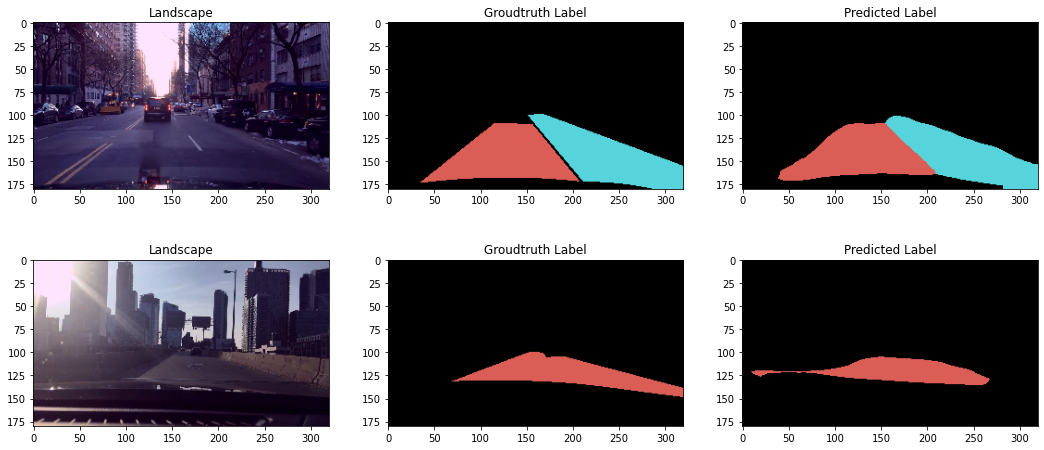

In [12]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples)

## Test on sample video